# Hyperparameter tuning and lags selection

Hyperparameter tuning is a key step in building accurate and robust machine learning models. Hyperparameters are configuration values that cannot be learned directly from data and must be defined by the user before training. These values can significantly affect model performance, and carefully tuning them helps improve both accuracy and generalization.

In forecasting models, the selection of **lags** (past time steps used as predictors) is considered an additional hyperparameter, as it directly influences the model's input structure and learning capacity.

Hyperparameter tuning consists of systematically evaluating combinations of hyperparameters (including lags) to find the configuration that yields the best predictive performance. The **skforecast** library supports several tuning strategies: **grid search**, **random search**, and **Bayesian search**. These strategies can be used with either [backtesting](../user_guides/backtesting.html) or [one-step-ahead validation](../user_guides/hyperparameter-tuning-and-lags-selection.html#one-step-ahead-validation) to determine the optimal parameter set for a given forecasting task.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

All <b>backtesting</b> and <b>hyperparameter search</b> functions in the <code>model_selection</code> module include the <code>n_jobs</code> argument, enabling <b>multi-process parallelization</b> to improve computational performance.

Its effectiveness depends on factors like the regressor type, the number of model fits to perform, and the volume of data. When <code>n_jobs</code> is set to <code>'auto'</code>, the level of parallelization is automatically determined using heuristic rules designed to select the most efficient configuration for each scenario.

For more information, see the guide <a href="../faq/parallelization-skforecast.html">Parallelization in skforecast</a>.

</div>

## Validation strategies

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ **Backtesting**: Simulates a real deployment scenario by generating multi-step forecasts in repeated iterations, using the defined forecast horizon and retraining frequency. This approach provides a realistic estimate of performance over time. Use the <code>[TimeSeriesFold](../api/model_selection.html#skforecast.model_selection._split.TimeSeriesFold)</code> class for this validation strategy. [More information](../user_guides/backtesting.html).

+ **One-Step-Ahead**: Evaluates model performance using only one-step-ahead forecasts ($t+1$). This method is faster, as it requires fewer iterations, but it only tests the model's performance in the immediate next time step. Use the <code>[OneStepAheadFold](../api/model_selection.html#skforecast.model_selection._split.OneStepAheadFold)</code> class for the one-step-ahead strategy. [More information](../user_guides/hyperparameter-tuning-and-lags-selection.html#one-step-ahead-validation).

Although the two methods may produce different results, they tend to converge on similar hyperparameter selections over time. The one-step-ahead method is faster than backtesting because it requires fewer iterations; however, it only tests the model's performance in the next immediate time step. For a more accurate multi-step performance estimate, it is recommended to backtest the final model.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

For a more detailed comparison of the results (**execution time** and **metric**) obtained with each strategy, visit <a href="../faq/parameters-search-backtesting-vs-one-step-ahead.html">Hyperparameters and lags search: backtesting vs one-step-ahead</a>.

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.plot import set_dark_theme
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    grid_search_forecaster,
    random_search_forecaster,
    bayesian_search_forecaster
)

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)
Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00 (n=29)


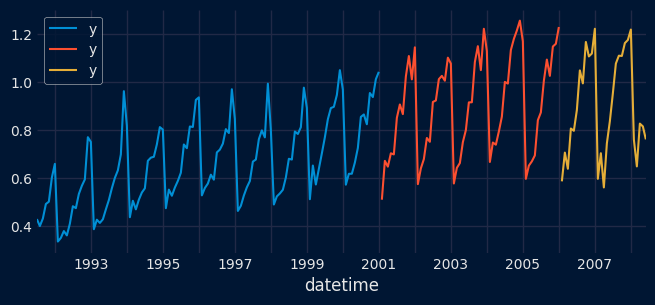

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}"
    f"  (n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}"
    f" (n={len(data.loc[end_val:])})"
)

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

## Grid search

Grid search is a popular hyperparameter tuning technique that evaluate an exaustive list of combinations of hyperparameters and lags to find the optimal configuration for a forecasting model. To perform a grid search with the **skforecast** library, two grids are needed: one with different lags (`lags_grid`) and another with the hyperparameters (`param_grid`).

The grid search process involves the following steps:

1. `grid_search_forecaster` replaces the `lags` argument with the first option appearing in `lags_grid`.

2. The function validates all combinations of hyperparameters presented in `param_grid` using [backtesting](../user_guides/backtesting.html) or [one-step-ahead validation](../user_guides/hyperparameter-tuning-and-lags-selection.html#one-step-ahead-validation) validation.

3. The function repeats these two steps until it has evaluated all possible combinations of lags and hyperparameters.

4. If `return_best = True`, the original forecaster is trained with the best lags and hyperparameters configuration found during the grid search process.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

When using <b>backtesting</b> as the validation strategy, the computational cost of the tuning largely depends on the strategy used to evaluate each hyperparameter combination. In general, the more re-trainings required, the longer the tuning process will take.

To speed up the prototyping phase, a two-step approach is recommended. First, run the search with <code>refit=False</code> to explore a broad range of values quickly. Then, refine the search within the most promising region using a tailored backtesting strategy aligned with the specific needs of the use case.

For more guidance, refer to the following resource: <a href="../user_guides/backtesting.html#which-strategy-should-i-use">Which backtesting strategy should I use?</a>.

</div>

In [ ]:
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 20]
}

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = '2001-01-01 23:59:00',  # Same as len(data.loc[:end_train])
         refit              = False
     )

results = grid_search_forecaster(
              forecaster    = forecaster,
              y             = data.loc[:end_val, 'y'],
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error',
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.04387531272712768


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 100}",0.043875,5,100
1,"[1, 2, 3]",lags_1,"{'max_depth': 10, 'n_estimators': 100}",0.043875,10,100
2,"[1, 2, 3]",lags_1,"{'max_depth': 15, 'n_estimators': 100}",0.043875,15,100
3,"[1, 2, 3, 20]",lags_3,"{'max_depth': 10, 'n_estimators': 100}",0.044074,10,100
4,"[1, 2, 3, 20]",lags_3,"{'max_depth': 5, 'n_estimators': 100}",0.044074,5,100
5,"[1, 2, 3, 20]",lags_3,"{'max_depth': 15, 'n_estimators': 100}",0.044074,15,100
6,"[1, 2, 3]",lags_1,"{'max_depth': 10, 'n_estimators': 50}",0.045423,10,50
7,"[1, 2, 3]",lags_1,"{'max_depth': 15, 'n_estimators': 50}",0.045423,15,50
8,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 50}",0.045423,5,50
9,"[1, 2, 3, 20]",lags_3,"{'max_depth': 10, 'n_estimators': 50}",0.046221,10,50


Since `return_best = True`, the forecaster object is updated with the best configuration found and trained with the whole data set. This means that the final model obtained from grid search will have the best combination of lags and hyperparameters that resulted in the highest performance metric. This final model can then be used for future predictions on new data.

In [4]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [1 2 3] 
Window features: None 
Window size: 3 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-01 12:24:24 
Last fit date: 2025-05-01 12:24:25 
Skforecast version: 0.16.0 
Python version: 3.12.9 
Forecaster id: None

## Random search

Random search is another hyperparameter tuning strategy available in the **skforecast** library. In contrast to grid search, which tries out all possible combinations of hyperparameters and lags, randomized search samples a fixed number of values from the specified possibilities. The number of combinations that are evaluated is given by `n_iter`.

It is important to note that random sampling is only applied to the model hyperparameters, but not to the lags. All lags specified by the user are evaluated.

In [5]:
# Random search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor hyperparameters
param_distributions = {
    'n_estimators': np.arange(start=10, stop=100, step=1, dtype=int),
    'max_depth': np.arange(start=5, stop=30, step=1, dtype=int)
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train]),
         refit              = False,
     )

results = random_search_forecaster(
              forecaster          = forecaster,
              y                   = data.loc[:end_val, 'y'],
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              n_iter              = 5,
              metric              = 'mean_squared_error',
              return_best         = True,
              random_state        = 123,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )
results.head(4)

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'n_estimators': np.int64(96), 'max_depth': np.int64(19)}
  Backtesting metric: 0.04313147793349785


,lags,lags_label,params,mean_squared_error,n_estimators,max_depth
0,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'n_estimators': 96, 'max_depth': 19}",0.043131,96,19
1,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'n_estimators': 94, 'max_depth': 28}",0.043171,94,28
2,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'n_estimators': 77, 'max_depth': 17}",0.043663,77,17
3,"[1, 2, 3]","[1, 2, 3]","{'n_estimators': 96, 'max_depth': 19}",0.043868,96,19


## Bayesian search

Grid and random search can yield good results, especially when the search space is well-defined. However, these methods do not consider past results, which limits their ability to focus on the most promising regions and avoid uninformative ones.

A more efficient alternative is **Bayesian optimization**, which builds a probabilistic model of the objective function, typically the validation metric (e.g. RMSE, AUC, accuracy). Based on the results observed so far, the algorithm iteratively refines the search, concentrating on regions with the highest potential. This approach reduces the number of evaluations needed by prioritizing the most relevant hyperparameter combinations. It is especially useful when the search space is large or model training is computationally expensive.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>lags_grid</code> argument is not required when using <code>bayesian_search_forecaster</code>. Instead, the <code>lags</code> can be included directly in the <code>search_space</code>, allowing them to be optimized jointly with the other regressor hyperparameters during the search.

</div>

In **skforecast**, Bayesian optimization is implemented using **Optuna** and its [`Study object`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study). The goal of the optimization is to **minimize the metric** returned by the validation strategy (either backtesting or one-step-ahead).

You can customize the optimization process by passing additional arguments through the `kwargs_create_study` and `kwargs_study_optimize` parameters. These are forwarded to Optuna’s [`create_study`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.create_study.html) and [`optimize method`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.optimize), respectively.

To define the **hyperparameter search space**, the `search_space` argument must be a function that takes an Optuna [Trial object](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial) and returns a dictionary of parameters to evaluate.

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )


# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [3, 5]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }
    
    return search_space


# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train]),  # Can use a date: '2001-01-01 23:59:00'
         refit              = False,
     )

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = data.loc[:end_val, 'y'],
                          search_space          = search_space,
                          cv                    = cv,
                          metric                = 'mean_absolute_error',
                          n_trials              = 10,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )
results.head(4)

  0%|          | 0/10 [00:00<?, ?it/s]

,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
0,"[1, 2, 3, 4, 5]","{'n_estimators': 19, 'min_samples_leaf': 3, 'm...",0.126995,19,3,sqrt
1,"[1, 2, 3]","{'n_estimators': 15, 'min_samples_leaf': 4, 'm...",0.153278,15,4,sqrt
2,"[1, 2, 3]","{'n_estimators': 13, 'min_samples_leaf': 3, 'm...",0.160396,13,3,sqrt
3,"[1, 2, 3, 4, 5]","{'n_estimators': 14, 'min_samples_leaf': 5, 'm...",0.172366,14,5,log2


The `best_trial` return contains the details of the trial that achieved the best result during optimization. For more information, refer to the [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [7]:
# Optuna best trial in the study
# ==============================================================================
best_trial

FrozenTrial(number=7, state=1, values=[0.1269945910624239], datetime_start=datetime.datetime(2025, 5, 1, 12, 24, 26, 777944), datetime_complete=datetime.datetime(2025, 5, 1, 12, 24, 26, 824529), params={'lags': 5, 'n_estimators': 19, 'min_samples_leaf': 3, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(3, 5)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=7, value=None)

## One-step-ahead validation

**One-Step-Ahead** evaluates model performance using only one-step-ahead forecasts ($t+1$). This method is faster, as it requires fewer iterations, but it only tests the model's performance in the immediate next time step. Use the <code>[OneStepAheadFold](../api/model_selection.html#skforecast.model_selection._split.OneStepAheadFold)</code> class for the one-step-ahead strategy.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

For a more detailed comparison of the results (**execution time** and **metric**) obtained with each strategy, visit <a href="../faq/parameters-search-backtesting-vs-one-step-ahead.html">Hyperparameters and lags search: backtesting vs one-step-ahead</a>.

</div>

In [ ]:
# Bayesian search with OneStepAheadFold
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )


# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [3, 5]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }
    
    return search_space


# Folds
cv = OneStepAheadFold(
    initial_train_size = len(data.loc[:end_train])  # Can use a date: '2001-01-01 23:59:00'
)

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = data.loc[:end_val, 'y'],
                          search_space          = search_space,
                          cv                    = cv,
                          metric                = 'mean_absolute_error',
                          n_trials              = 10,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )
results.head(4)

╭─────────────────────────── OneStepAheadValidationWarning ────────────────────────────╮
│ One-step-ahead predictions are used for faster model comparison, but they may not    │
│ fully represent multi-step prediction performance. It is recommended to backtest the │
│ final model for a more accurate multi-step performance estimate.                     │
│                                                                                      │
│ Category : OneStepAheadValidationWarning                                             │
│ Location :                                                                           │
│ /home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/skfore │
│ cast/model_selection/_utils.py:693                                                   │
│ Suppress : warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)   │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/10 [00:00<?, ?it/s]

,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
0,"[1, 2, 3, 4, 5]","{'n_estimators': 20, 'min_samples_leaf': 6, 'm...",0.180137,20,6,log2
1,"[1, 2, 3, 4, 5]","{'n_estimators': 14, 'min_samples_leaf': 5, 'm...",0.180815,14,5,log2
2,"[1, 2, 3, 4, 5]","{'n_estimators': 16, 'min_samples_leaf': 9, 'm...",0.187584,16,9,log2
3,"[1, 2, 3]","{'n_estimators': 14, 'min_samples_leaf': 7, 'm...",0.188359,14,7,log2


## Hyperparameter tuning with custom metric

In addition to standard metrics such as `mean_squared_error` or `mean_absolute_error`, users can define **custom metric functions**, provided they accept the arguments `y_true` (true values), `y_pred` (predicted values) and optionally `y_train` (train values), and return a numeric value (`float` or `int`).

This flexibility allows evaluating model performance under specific conditions, for example, focusing only on certain months, days, non-holiday periods, or the last step of the forecast horizon.

To illustrate this, consider a scenario where a 12-month forecast is generated, but only the last three months of each year are relevant for evaluation. This can be handled by defining a custom metric function that filters the desired months before computing the error, and then passing that function to the backtesting or hyperparameter tuning process.

The example below shows how to optimize model parameters using a custom metric focused on the last three months of each forecasted year.



<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

More information about <b>time series forecasting metrics</b> can be found in the <a href="../user_guides/metrics.html">Metrics</a> guide.

</div>

In [ ]:
# Custom metric
# ==============================================================================
def custom_metric(y_true, y_pred, y_train=None):
    """
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_squared_error(y_true[mask], y_pred[mask])
    
    return metric

In [10]:
# Grid search hyperparameter and lags with custom metric
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train]),
         refit              = False,
     )

results = grid_search_forecaster(
              forecaster    = forecaster,
              y             = data.loc[:end_val, 'y'],
              cv            = cv,
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              metric        = custom_metric,
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )

results.head(4)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.0681822427249296


,lags,lags_label,params,custom_metric,max_depth,n_estimators
0,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.068182,5,100
1,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.068182,10,100
2,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.068182,15,100
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.070472,5,100


## Compare multiple metrics

The functions `grid_search_forecaster`, `random_search_forecaster`, and `bayesian_search_forecaster` support the evaluation of **multiple metrics** for each forecaster configuration by passing a `list` of metric functions. This list can include both built-in metrics (e.g. `mean_squared_error`, `mean_absolute_error`) and custom-defined ones.

When multiple metrics are provided, the **first metric in the list** is used to select the best model.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

More information about <b>time series forecasting metrics</b> can be found in the <a href="../user_guides/metrics.html">Metrics</a> guide.

</div>

In [11]:
# Grid search hyperparameter and lags with multiple metrics
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train]),
         refit              = False,
     )

results = grid_search_forecaster(
              forecaster    = forecaster,
              y             = data.loc[:end_val, 'y'],
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = ['mean_absolute_error', mean_squared_error, custom_metric],
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )

results.head(4)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.18359367014650177


,lags,lags_label,params,mean_absolute_error,mean_squared_error,custom_metric,max_depth,n_estimators
0,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.183594,0.043875,0.070472,5,100
1,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.183594,0.043875,0.070472,10,100
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 15, 'n_estimators': 100}",0.183594,0.043875,0.070472,15,100
3,"[1, 2, 3, 20]","[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.184901,0.044074,0.068182,10,100


## Compare multiple regressors

The search process can be easily extended to compare several machine learning models. This can be achieved by using a simple for loop that iterates over each regressor and applying the desired function (for example, `grid_search_forecaster`). This approach allows for a more thorough exploration and can help you select the best model.

In [12]:
# Models to compare
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

models = [
    RandomForestRegressor(random_state=123), 
    LGBMRegressor(random_state=123, verbose=-1),
    Ridge(random_state=123)
]

# Hyperparameter to search for each model
param_grids = {
    'RandomForestRegressor': {'n_estimators': [50, 100], 'max_depth': [5, 15]},
    'LGBMRegressor': {'n_estimators': [20, 50], 'max_depth': [5, 10]},
    'Ridge': {'alpha': [0.01, 0.1, 1]}
}

# Lags used as predictors
lags_grid = [3, 5]

# Folds
cv = TimeSeriesFold(
         steps              = 3,
         initial_train_size = len(data.loc[:end_train]),
         refit              = False,
     )

df_results = pd.DataFrame()
for i, model in enumerate(models):

    print(f"Grid search for regressor: {model}")
    print("-------------------------")

    forecaster = ForecasterRecursive(
                     regressor = model,
                     lags      = 3
                 )

    # Regressor hyperparameters
    param_grid = param_grids[list(param_grids)[i]]

    results = grid_search_forecaster(
                  forecaster    = forecaster,
                  y             = data.loc[:end_val, 'y'],
                  param_grid    = param_grid,
                  lags_grid     = lags_grid,
                  cv            = cv,
                  metric        = 'mean_squared_error',
                  return_best   = False,
                  n_jobs        = 'auto',
                  verbose       = False,
                  show_progress = True
              )
    
    # Create a column with model name
    results['model'] = list(param_grids)[i]
    
    df_results = pd.concat([df_results, results])

df_results = df_results.sort_values(by='mean_squared_error')
df_results.head(10)

Grid search for regressor: RandomForestRegressor(random_state=123)
-------------------------


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

/home/joaquin/miniconda3/envs/skforecast_16_py12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=13937) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


Grid search for regressor: LGBMRegressor(random_state=123, verbose=-1)
-------------------------


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Grid search for regressor: Ridge(random_state=123)
-------------------------


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators,model,alpha
1,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 50}",0.050180,5.0,50.0,LGBMRegressor,NaN
0,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 50}",0.050180,10.0,50.0,LGBMRegressor,NaN
3,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.050907,10.0,50.0,LGBMRegressor,NaN
2,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.050907,5.0,50.0,LGBMRegressor,NaN
5,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 20}",0.056990,5.0,20.0,LGBMRegressor,NaN
4,"[1, 2, 3]","[1, 2, 3]","{'max_depth': 10, 'n_estimators': 20}",0.056990,10.0,20.0,LGBMRegressor,NaN
7,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 20}",0.057542,10.0,20.0,LGBMRegressor,NaN
6,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 20}",0.057542,5.0,20.0,LGBMRegressor,NaN
0,"[1, 2, 3]","[1, 2, 3]",{'alpha': 0.01},0.059814,NaN,NaN,Ridge,0.01
1,"[1, 2, 3]","[1, 2, 3]",{'alpha': 0.1},0.060078,NaN,NaN,Ridge,0.10


## Saving results to file

The results of the hyperparameter search process can be saved to a file by setting the `output_file` argument to the desired path. The results will be saved in a tab-separated values (TSV) format containing the hyperparameters, lags, and metrics of each configuration evaluated during the search. 

The saving process occurs after each hyperparameter evaluation, which means that if the optimization is stopped in the middle of the process, the logs of the first part of the evaluation have already been stored in the file. This can be useful for further analysis or to keep a record of the tuning process.

In [13]:
# Save results to file
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10  # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data.loc[:end_train]),
         refit              = False
     )

results = grid_search_forecaster(
              forecaster    = forecaster,
              y             = data.loc[:end_val, 'y'],
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error',
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True,
              output_file   = "results_grid_search.txt"
          )

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.04387531272712768


In [14]:
# Read results file
# ==============================================================================
pd.read_csv("results_grid_search.txt", sep="\t")

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,[1 2 3],[1 2 3],"{'max_depth': 5, 'n_estimators': 50}",0.045423,5,50
1,[1 2 3],[1 2 3],"{'max_depth': 5, 'n_estimators': 100}",0.043875,5,100
2,[1 2 3],[1 2 3],"{'max_depth': 10, 'n_estimators': 50}",0.045423,10,50
3,[1 2 3],[1 2 3],"{'max_depth': 10, 'n_estimators': 100}",0.043875,10,100
4,[1 2 3],[1 2 3],"{'max_depth': 15, 'n_estimators': 50}",0.045423,15,50
5,[1 2 3],[1 2 3],"{'max_depth': 15, 'n_estimators': 100}",0.043875,15,100
6,[ 1 2 3 4 5 6 7 8 9 10],[ 1 2 3 4 5 6 7 8 9 10],"{'max_depth': 5, 'n_estimators': 50}",0.051399,5,50
7,[ 1 2 3 4 5 6 7 8 9 10],[ 1 2 3 4 5 6 7 8 9 10],"{'max_depth': 5, 'n_estimators': 100}",0.047896,5,100
8,[ 1 2 3 4 5 6 7 8 9 10],[ 1 2 3 4 5 6 7 8 9 10],"{'max_depth': 10, 'n_estimators': 50}",0.051399,10,50
9,[ 1 2 3 4 5 6 7 8 9 10],[ 1 2 3 4 5 6 7 8 9 10],"{'max_depth': 10, 'n_estimators': 100}",0.047896,10,100
